In [1]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import janitor as jn
from utils import ecdf
from sklearn.preprocessing import LabelEncoder

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Problem Type

The Bayesian estimation model is widely applicable across a number of scenarios. The classical scenario is when we have an experimental design where there is a control vs. a treatment, and we want to know what the difference is between the two. Here, "estimation" is used to estimate the "true" value for the control and the "true" value for the treatment, and the "Bayesian" part refers to the computation of the uncertainty surrounding the parameter. 

Bayesian estimation's advantages over the classical t-test was first described by John Kruschke (2013). 

In this notebook, I provide a concise implementation suitable for two-sample and multi-sample inference.

## Data structure

To use it with this model, the data should be structured as such:

- Each row is one measurement.
- The columns should indicate, at the minimum:
    - What treatment group the sample belonged to.
    - The measured value.

## Extensions to the model

As of now, the model only samples posterior distributions of measured values. The model, then, may be extended to compute differences in means (sample vs. control) or effect sizes, complete with uncertainty around it. Use `pm.Deterministic(...)` to ensure that those statistics' posterior distributions, i.e. uncertainty, are also computed.

## Reporting summarized findings

Here are examples of how to summarize the findings.

> Treatment group A was greater than control by x units (95% HPD: [`lower`, `upper`]). 

> Treatment group A was higher than control (effect size 95% HPD: [`lower`, `upper`]). 

## Other notes

Here, we make a few modelling choices.

1. We care only about the `normalized_measurement` column, and so we choose the t-distribution to model it, as we don't have a good "mechanistic" model that incorporates measurement error of OD600 and 'measurement'.

In [2]:
# Read in the data
df = pd.read_csv('../datasets/biofilm.csv')

# Use pyjanitor for data cleaning.
df = (jn.DataFrame(df)
      .label_encode(columns=['isolate'])  # encode isolate as labels.
     )

# Convert continuous columns to floatX for GPU compatibility.
continuous_cols = ['OD600', 'ST', 'replicate', 'measurement', 'normalized_measurement']
for c in continuous_cols:
    df[c] = pm.floatX(df[c])

# Display a subset of the data.
df.head()

,experiment,isolate,ST,OD600,measurement,replicate,normalized_measurement,isolate_enc
0,1,1,4.0,0.461,0.317,1.0,0.687636,0
1,1,2,55.0,0.346,0.434,1.0,1.254335,7
2,1,3,55.0,0.356,0.917,1.0,2.575843,8
3,1,4,4.0,0.603,1.061,1.0,1.759536,9
4,1,5,330.0,0.444,3.701,1.0,8.335586,10


# Model Specification

Below, we define the model.

A visual representation of the model is below.

![](../images/biofilm.png)

In [3]:
with pm.Model() as best:
    nu = pm.Exponential('nu_minus_one', lam=1/30) + 1
    
    fold = pm.Flat('fold', shape=len(set(df['isolate_enc'])))
    
    var = pm.HalfCauchy('var', beta=1, shape=len(set(df['isolate_enc'])))
    
    mu = fold[df['isolate_enc'].values]
    sd = var[df['isolate_enc'].values]
    
    like = pm.StudentT('like', mu=mu, sd=sd, nu=nu, 
                       observed=df['normalized_measurement'])
    
    # Compute differences
    diffs = pm.Deterministic('differences', fold[1:] - fold[0])

Sample from the posterior distribution.

In [4]:
with best:
    trace = pm.sample(draws=2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [var_log__, fold, nu_minus_one_log__]
100%|██████████| 2500/2500 [00:08<00:00, 311.10it/s]


Check for convergence using the traceplot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26a41898>,
      dtype=object)

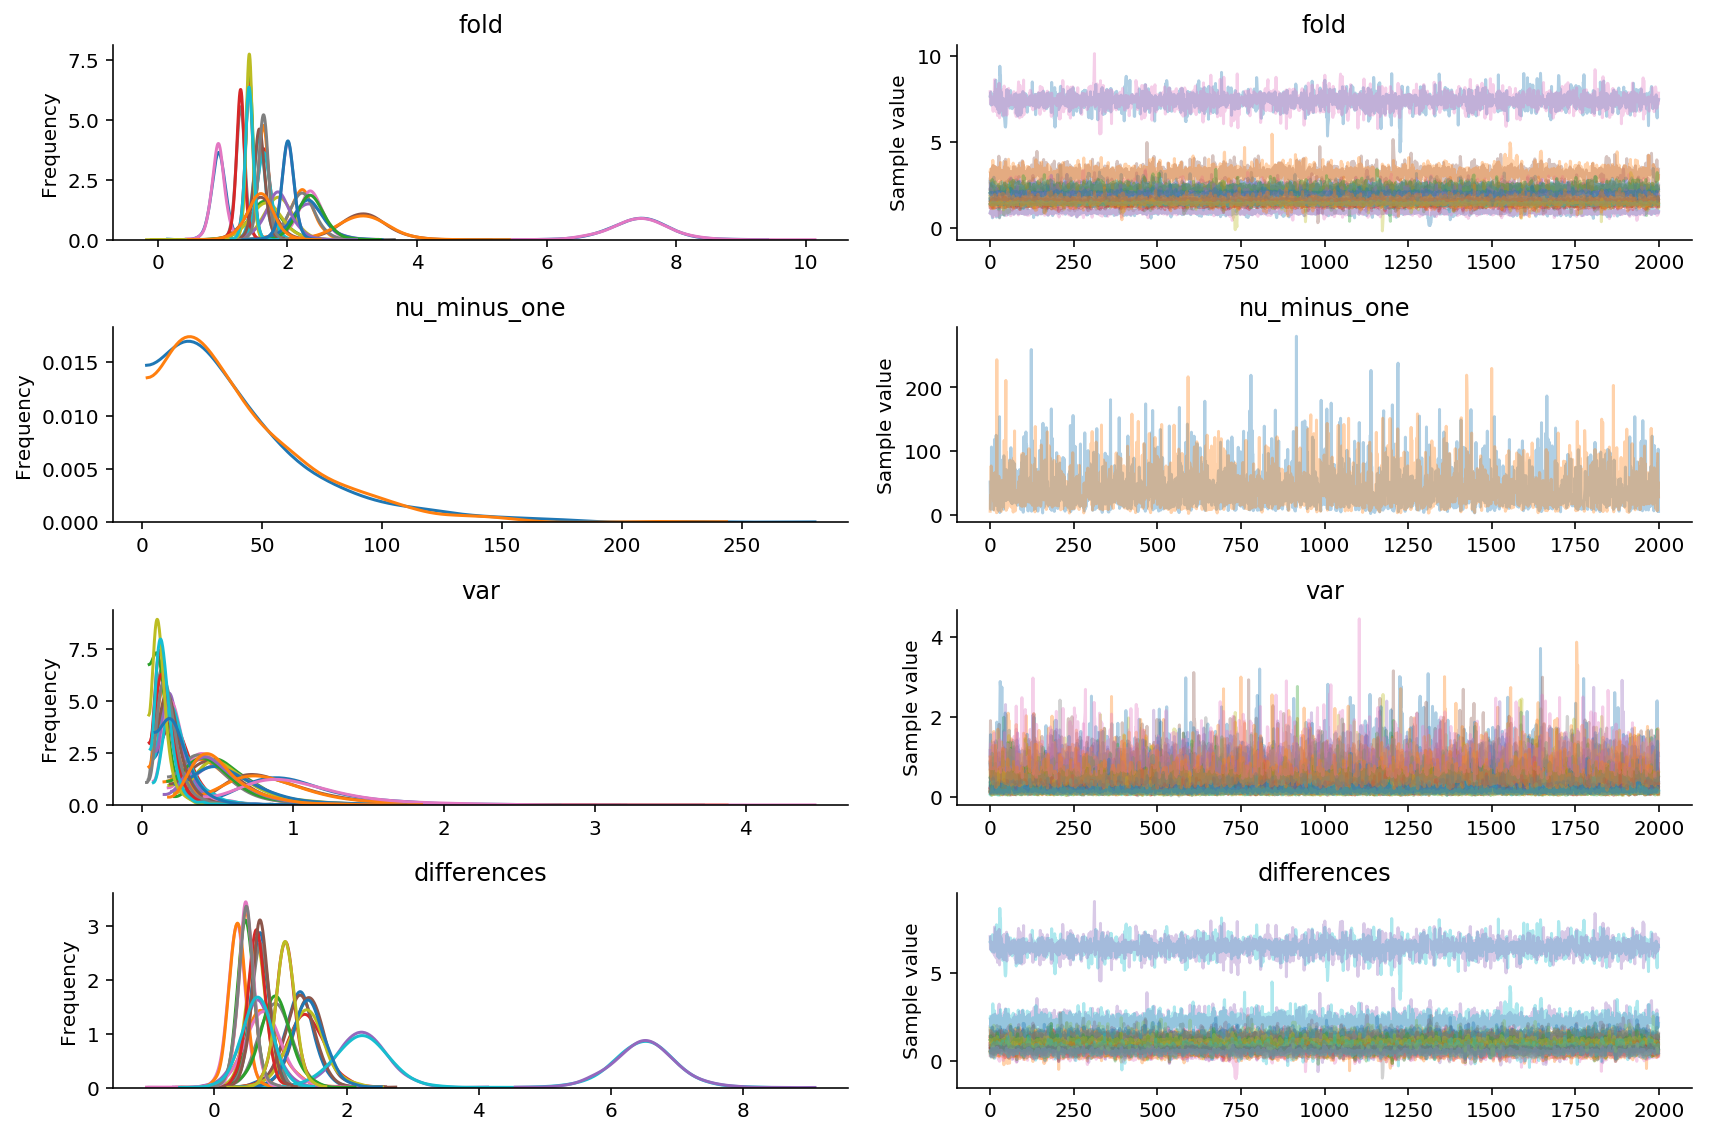

In [5]:
pm.traceplot(trace)

Looking at the traces, yes, everything looks more or less like a hairy caterpillar. This means that sampling went well, and has converged, thus we have a good MCMC estimator of the posterior distribution.

I need a mapping of isolate to its encoding - will come in handy below.

In [6]:
mapping = dict(zip(df['isolate_enc'], df['isolate']))
mapping

{0: '1',
 7: '2',
 8: '3',
 9: '4',
 10: '5',
 11: '6',
 12: '7',
 13: '8',
 14: '9',
 1: '10',
 2: '11',
 3: '12',
 4: '13',
 5: '14',
 6: '15',
 15: 'ATCC_29212'}

Let's use the Forest Plot to summarize how the strains differ from one another.

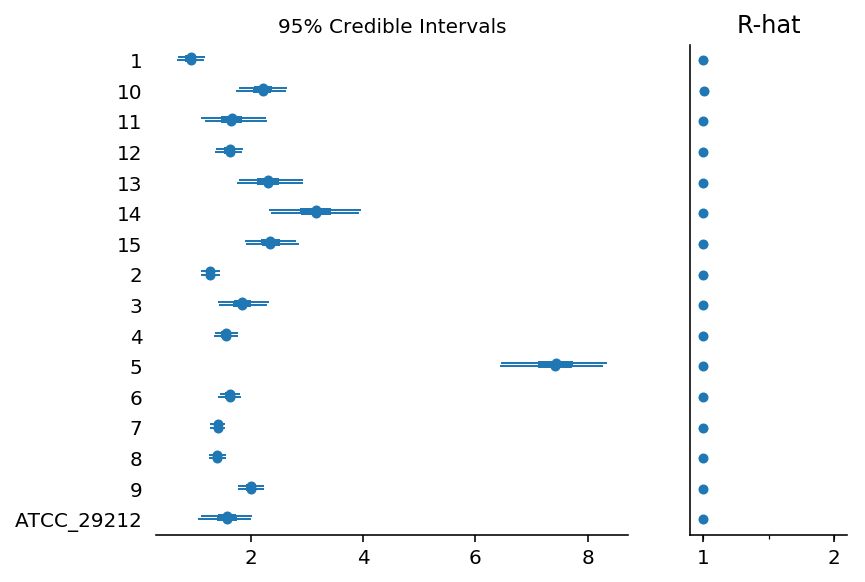

In [15]:
ylabels = [mapping[i] for i in sorted(mapping.keys())]
pm.forestplot(trace, varnames=['fold'], ylabels=ylabels)

It's quite clear that:

- Strain 5 is very good at forming biofilms.
- Strain 1 (control strain) is not good at forming biofilms.

Let's look at the difference between the strains.

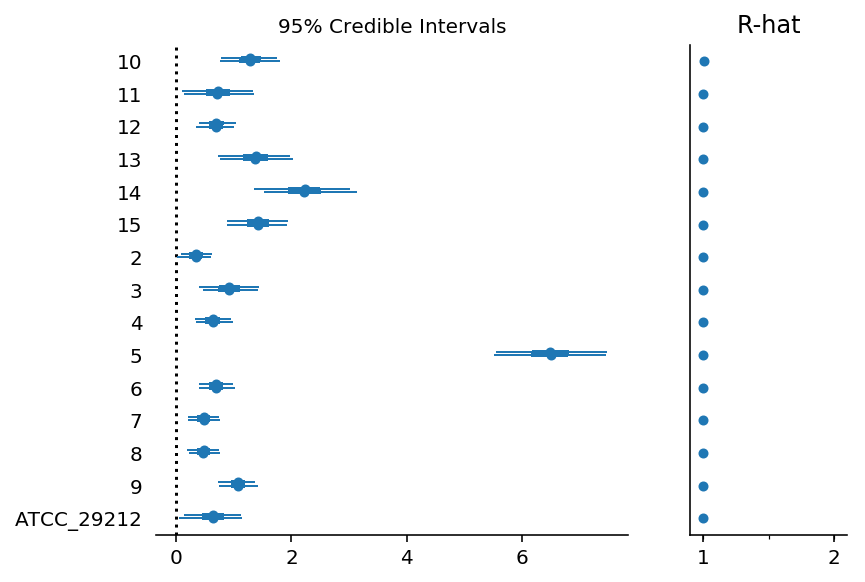

In [17]:
pm.forestplot(trace, varnames=['differences'], ylabels=ylabels[1:])

Apart from Strain 2, none of the other strains' difference HPDs cross "zero".

This means that they all would be considered to be "statistically significantly different" from strain 1.

Let's check the variances, just to see if there's a difference in that.

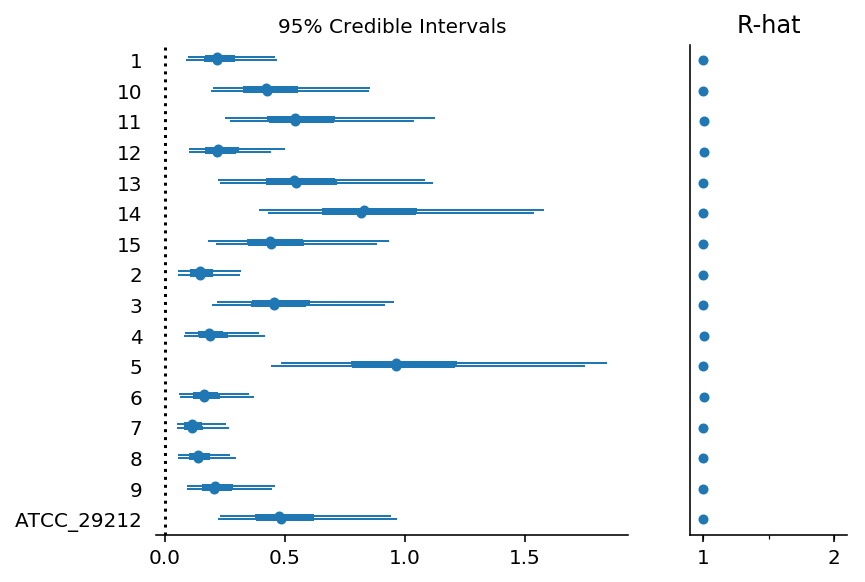

In [19]:
pm.forestplot(trace, varnames=['var'], ylabels=ylabels)

It is clear that there are a number of strains for whom the variance is similar. Without better information, though, we would not be warranted to impose a similarity structure on the data.

# Model Check

Let's see if we can generate PPC samples that look similar. Admittedly, there's a bit of an art to checking here - there's only 6 measurements per strain, so it's not like we have a lot of data to work with.

In [8]:
samples = pm.sample_ppc(trace, model=best)
samples['like'].shape

100%|██████████| 2000/2000 [00:01<00:00, 1300.23it/s]


(2000, 96)

In [9]:
# We want indices for each of the samples.
indices = dict()
for enc, iso in mapping.items():
    idxs = list(df[df['isolate_enc'] == enc].index)
    indices[iso] = idxs
indices

{'1': [0, 16, 32, 48, 64, 80],
 '2': [1, 17, 33, 49, 65, 81],
 '3': [2, 18, 34, 50, 66, 82],
 '4': [3, 19, 35, 51, 67, 83],
 '5': [4, 20, 36, 52, 68, 84],
 '6': [5, 21, 37, 53, 69, 85],
 '7': [6, 22, 38, 54, 70, 86],
 '8': [7, 23, 39, 55, 71, 87],
 '9': [8, 24, 40, 56, 72, 88],
 '10': [9, 25, 41, 57, 73, 89],
 '11': [10, 26, 42, 58, 74, 90],
 '12': [11, 27, 43, 59, 75, 91],
 '13': [12, 28, 44, 60, 76, 92],
 '14': [13, 29, 45, 61, 77, 93],
 '15': [14, 30, 46, 62, 78, 94],
 'ATCC_29212': [15, 31, 47, 63, 79, 95]}

In [10]:
samples['like'][:, idxs].mean(axis=1)

array([1.26932376, 1.34137183, 2.03674103, ..., 1.39138089, 1.521032  ,
       1.64292784])

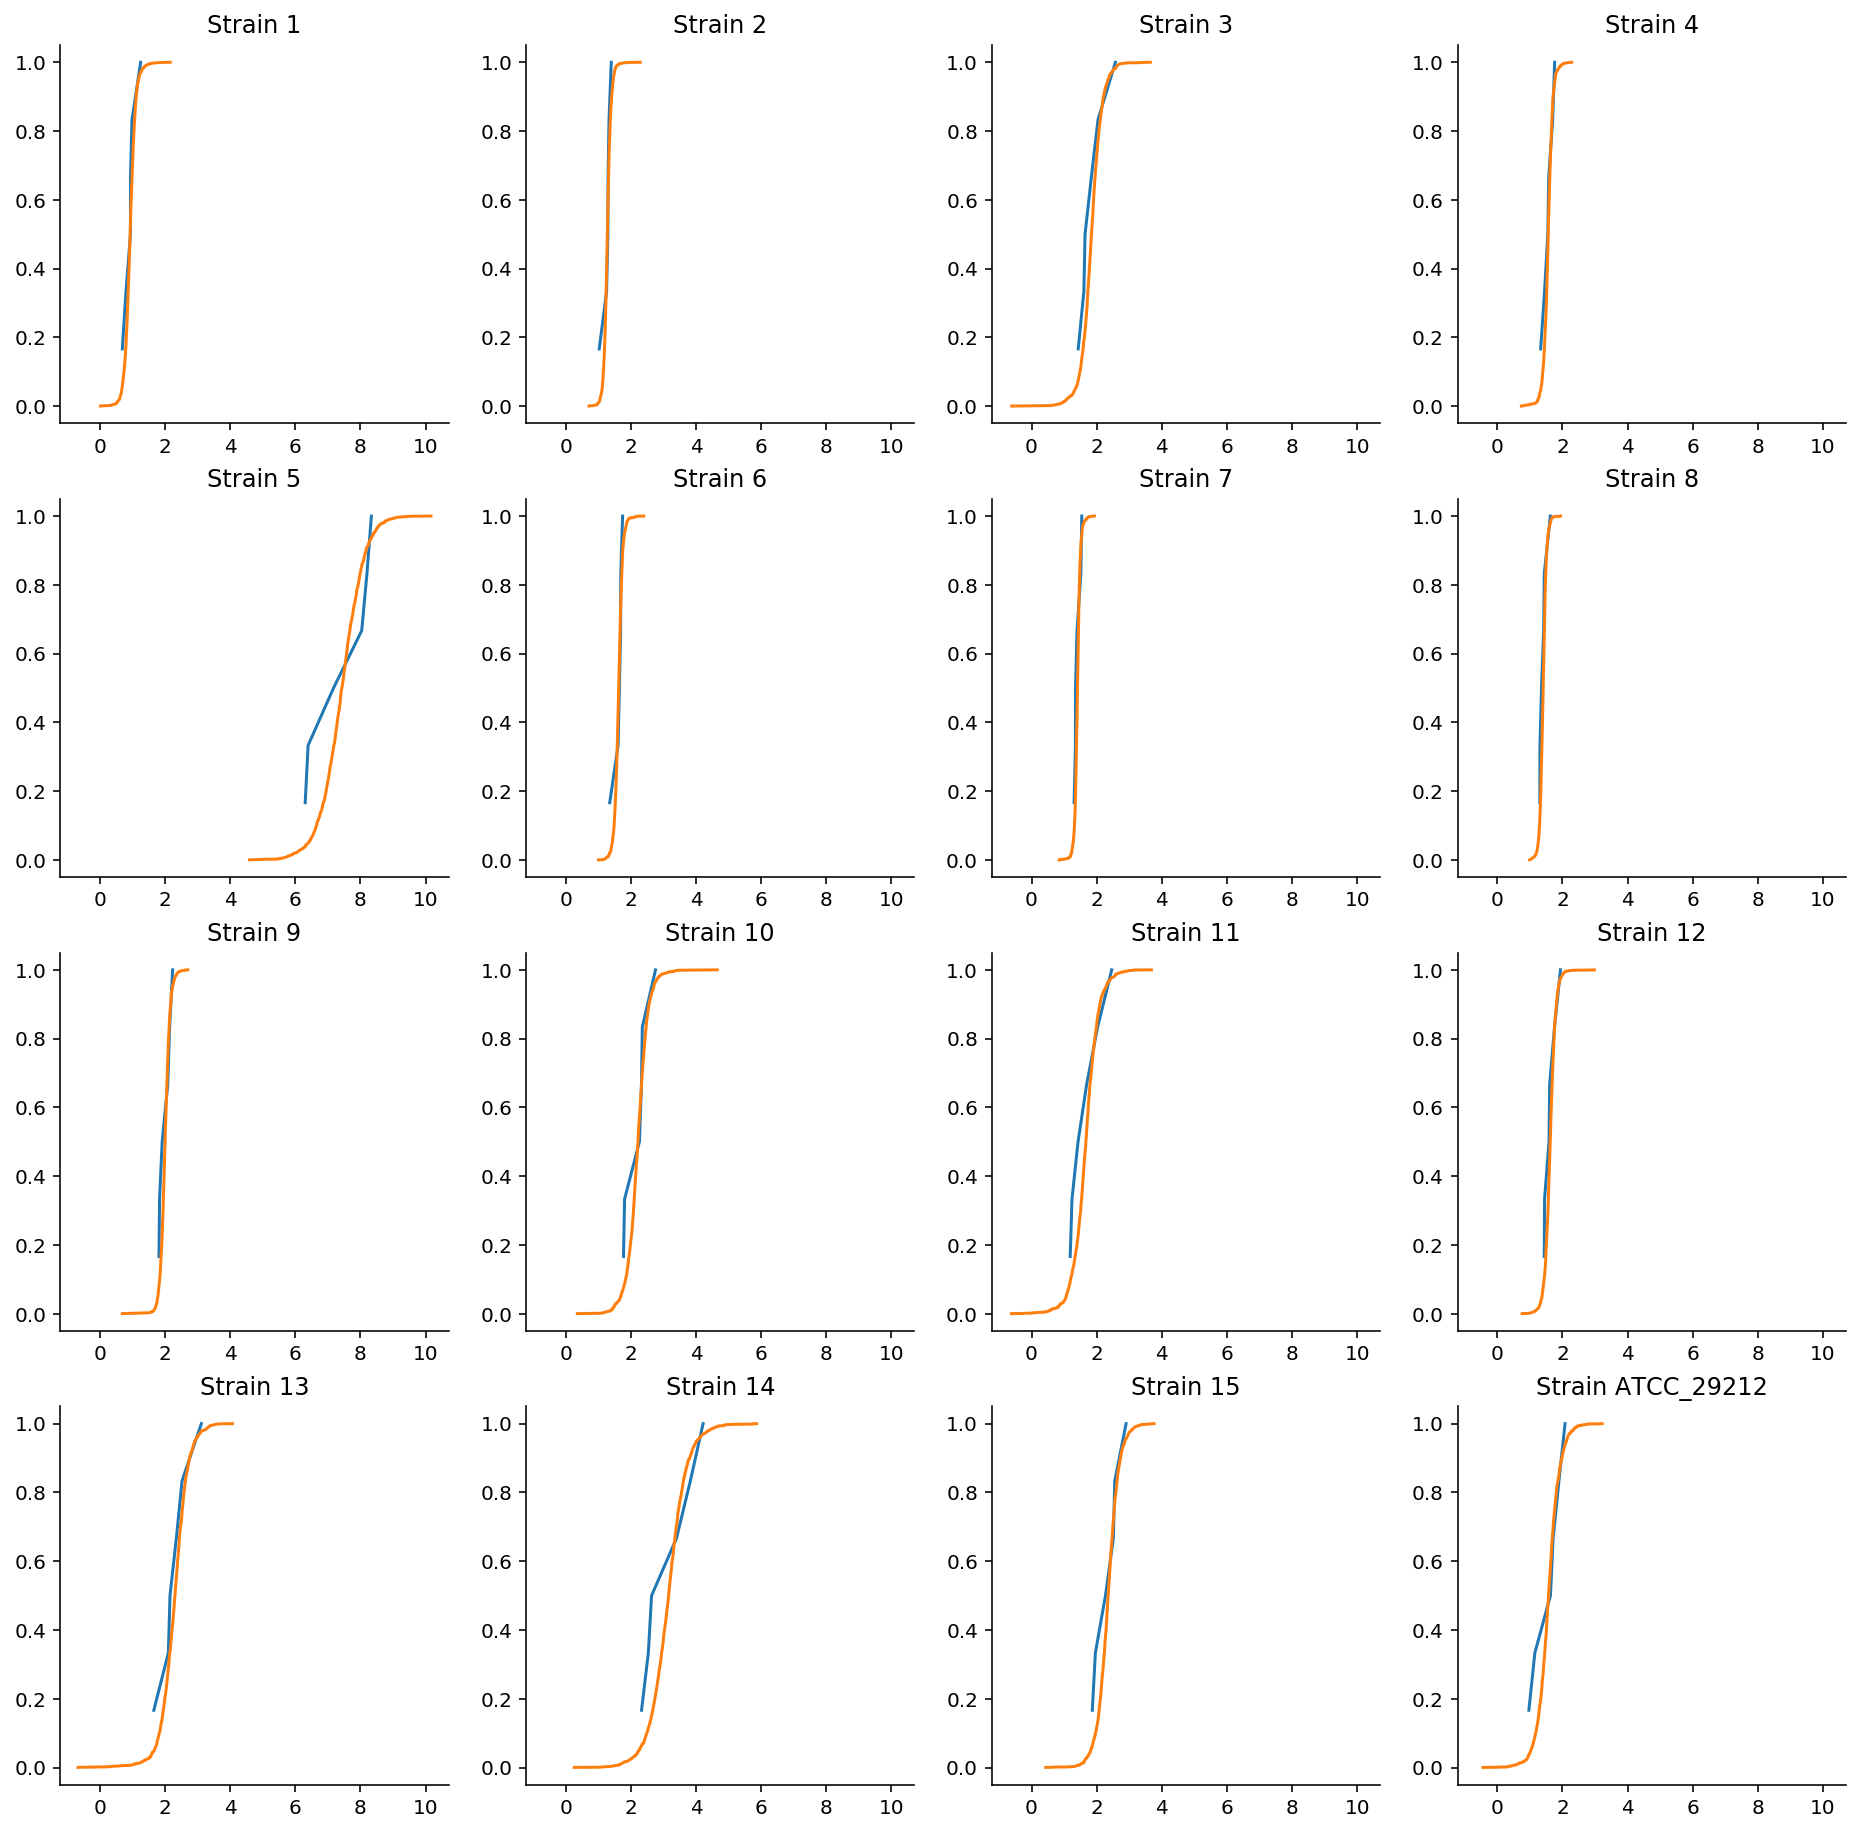

In [11]:
# Make PPC plot for one of the groups.
fig = plt.figure(figsize=(16, 16))
gs = GridSpec(nrows=4, ncols=4)
axes = dict()


for i, (strain, idxs) in enumerate(indices.items()):
    if i > 0:
        ax = fig.add_subplot(gs[i], sharex=axes[0])
    else:
        ax = fig.add_subplot(gs[i])
    x, y = ecdf(df.iloc[idxs]['normalized_measurement'])
    ax.plot(x, y, label='data')
    x, y = ecdf(samples['like'][:, idxs].mean(axis=1))
    ax.plot(x, y, label='ppc')
    ax.set_title(f'Strain {strain}')
    axes[i] = ax

While the PPC samples are generally okay, the StudentT distribution does give some long-tail values, including those that are negative. Given the measurements at hand, negative values would be considered "absurd" values. 

If I had more time, I might experiment with the use of a different likelihood distribution. However, this is a good enough first start model.